In [162]:
clear all

In [163]:
import torch
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.transforms import Compose
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [164]:
n_epochs = 5
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 1000
learning_rate = 0.00001
log_interval = 10

In [165]:
class CustomMNISTDataset(Dataset):

    def __init__(self, images, transform=None):
        self.len = images.shape[0]
        self.images = images
        self.means = [torch.mean(images[i].float()) for i in range(len(images))]
        self.transform = transform

    def __getitem__(self, index):
        return self.images[index], self.means[index]

    def __len__(self):
        return self.len
    
    
train = datasets.MNIST(root='../data', train=True, transform=Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                        , download=True)

test = datasets.MNIST(root='../data', train=False, transform=Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                        , download=True)

train_dataset = CustomMNISTDataset(train.data, transform=transforms.ToTensor)
test_dataset = CustomMNISTDataset(test.data, transform=transforms.ToTensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)


In [166]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [167]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_losses = []
train_counter = []
test_predicted = []
test_actual = []

In [168]:
def train(epoch):
    network.train()
    for batch_idx, (data, means) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = network(data.unsqueeze(1).float())
        loss = criterion(outputs, means.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')

In [169]:
def test():
    network.eval()
    
    test_predicted = []
    test_actual_means = []
    with torch.no_grad():
        for data, means in test_loader:
            output = network(data.unsqueeze(1).float())
            test_predicted.append(output.numpy())
            test_actual_means.append(means.numpy())

    test_predicted = [a.squeeze().tolist() for a in test_predicted]
    flat_predicted = [item for sublist in test_predicted for item in sublist]

    test_actual_means = [a.squeeze().tolist() for a in test_actual_means]
    flat_actual_means = [item for sublist in test_actual_means for item in sublist]
    
    plt.scatter(range(0,100),  flat_predicted[:100])
    plt.scatter(range(0,100) , flat_actual_means[:100])
    plt.xlabel("Examples")
    plt.ylabel("Mean")
    plt.show()

    mse = mean_squared_error(flat_actual_means, flat_predicted)
    r_square = r2_score(flat_actual_means, flat_predicted)
    print(f'The Mean Squared Error: {mse}, and the R^2: {r_square}')

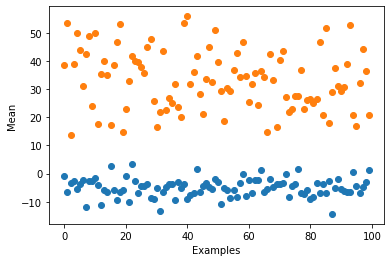

The Mean Squared Error: 1667.5334394086262, and the R^2: -12.400086642115657
Train Epoch: 1 [0/60000 (0%)]	Loss: 2262.804688
Train Epoch: 1 [640/60000 (1%)]	Loss: 2039.345459
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2042.415649
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1771.981201
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2181.805908
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1639.489746
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1436.303101
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1464.321777
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1356.855835
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1469.888306
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1042.681641
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1336.875977
Train Epoch: 1 [7680/60000 (13%)]	Loss: 934.727783
Train Epoch: 1 [8320/60000 (14%)]	Loss: 760.413940
Train Epoch: 1 [8960/60000 (15%)]	Loss: 803.786865
Train Epoch: 1 [9600/60000 (16%)]	Loss: 654.925781
Train Epoch: 1 [10240/60000 (17%)]	Loss: 939.112671
Train Epoch: 1 [10880/60000 (18%)]	Loss: 696.272644
Trai

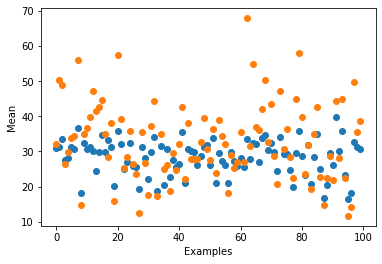

The Mean Squared Error: 78.8018193658486, and the R^2: 0.36675860159469964
Train Epoch: 2 [0/60000 (0%)]	Loss: 214.910843
Train Epoch: 2 [640/60000 (1%)]	Loss: 248.895203
Train Epoch: 2 [1280/60000 (2%)]	Loss: 294.261230
Train Epoch: 2 [1920/60000 (3%)]	Loss: 328.262207
Train Epoch: 2 [2560/60000 (4%)]	Loss: 224.815735
Train Epoch: 2 [3200/60000 (5%)]	Loss: 310.181793
Train Epoch: 2 [3840/60000 (6%)]	Loss: 171.970703
Train Epoch: 2 [4480/60000 (7%)]	Loss: 233.854385
Train Epoch: 2 [5120/60000 (9%)]	Loss: 260.097900
Train Epoch: 2 [5760/60000 (10%)]	Loss: 279.274628
Train Epoch: 2 [6400/60000 (11%)]	Loss: 301.090332
Train Epoch: 2 [7040/60000 (12%)]	Loss: 195.048065
Train Epoch: 2 [7680/60000 (13%)]	Loss: 237.256897
Train Epoch: 2 [8320/60000 (14%)]	Loss: 152.749725
Train Epoch: 2 [8960/60000 (15%)]	Loss: 264.955292
Train Epoch: 2 [9600/60000 (16%)]	Loss: 237.861832
Train Epoch: 2 [10240/60000 (17%)]	Loss: 241.076645
Train Epoch: 2 [10880/60000 (18%)]	Loss: 289.523651
Train Epoch: 2 [11

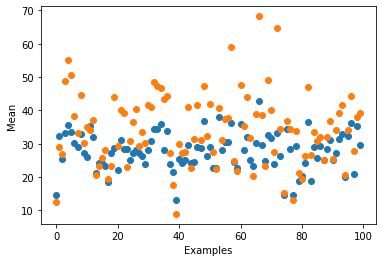

The Mean Squared Error: 78.37895955561206, and the R^2: 0.37015664925043223
Train Epoch: 3 [0/60000 (0%)]	Loss: 186.158310
Train Epoch: 3 [640/60000 (1%)]	Loss: 223.964096
Train Epoch: 3 [1280/60000 (2%)]	Loss: 154.294571
Train Epoch: 3 [1920/60000 (3%)]	Loss: 149.848068
Train Epoch: 3 [2560/60000 (4%)]	Loss: 200.404953
Train Epoch: 3 [3200/60000 (5%)]	Loss: 156.965805
Train Epoch: 3 [3840/60000 (6%)]	Loss: 170.342117
Train Epoch: 3 [4480/60000 (7%)]	Loss: 235.922455
Train Epoch: 3 [5120/60000 (9%)]	Loss: 155.897217
Train Epoch: 3 [5760/60000 (10%)]	Loss: 222.591888
Train Epoch: 3 [6400/60000 (11%)]	Loss: 189.895386
Train Epoch: 3 [7040/60000 (12%)]	Loss: 190.469055
Train Epoch: 3 [7680/60000 (13%)]	Loss: 205.709869
Train Epoch: 3 [8320/60000 (14%)]	Loss: 169.054245
Train Epoch: 3 [8960/60000 (15%)]	Loss: 146.255890
Train Epoch: 3 [9600/60000 (16%)]	Loss: 245.472870
Train Epoch: 3 [10240/60000 (17%)]	Loss: 262.257568
Train Epoch: 3 [10880/60000 (18%)]	Loss: 170.745300
Train Epoch: 3 [1

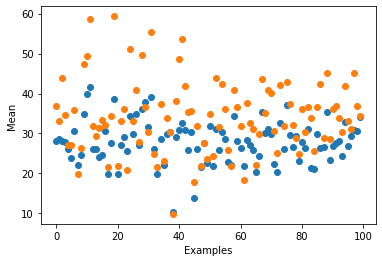

The Mean Squared Error: 74.44989050872545, and the R^2: 0.40173014841204857
Train Epoch: 4 [0/60000 (0%)]	Loss: 117.180954
Train Epoch: 4 [640/60000 (1%)]	Loss: 219.031464
Train Epoch: 4 [1280/60000 (2%)]	Loss: 217.892517
Train Epoch: 4 [1920/60000 (3%)]	Loss: 164.163406
Train Epoch: 4 [2560/60000 (4%)]	Loss: 149.490814
Train Epoch: 4 [3200/60000 (5%)]	Loss: 180.609314
Train Epoch: 4 [3840/60000 (6%)]	Loss: 138.522644
Train Epoch: 4 [4480/60000 (7%)]	Loss: 165.121429
Train Epoch: 4 [5120/60000 (9%)]	Loss: 187.131989
Train Epoch: 4 [5760/60000 (10%)]	Loss: 197.673798
Train Epoch: 4 [6400/60000 (11%)]	Loss: 208.823105
Train Epoch: 4 [7040/60000 (12%)]	Loss: 122.660660
Train Epoch: 4 [7680/60000 (13%)]	Loss: 195.683517
Train Epoch: 4 [8320/60000 (14%)]	Loss: 148.738083
Train Epoch: 4 [8960/60000 (15%)]	Loss: 182.609619
Train Epoch: 4 [9600/60000 (16%)]	Loss: 209.941376
Train Epoch: 4 [10240/60000 (17%)]	Loss: 118.506958
Train Epoch: 4 [10880/60000 (18%)]	Loss: 167.801208
Train Epoch: 4 [1

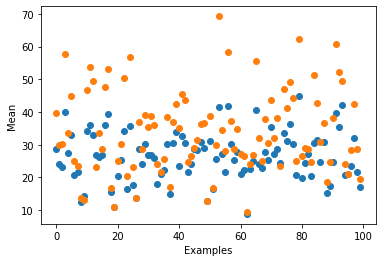

The Mean Squared Error: 76.61826267761518, and the R^2: 0.38430538543651327
Train Epoch: 5 [0/60000 (0%)]	Loss: 171.798523
Train Epoch: 5 [640/60000 (1%)]	Loss: 129.969620
Train Epoch: 5 [1280/60000 (2%)]	Loss: 107.721695
Train Epoch: 5 [1920/60000 (3%)]	Loss: 135.511154
Train Epoch: 5 [2560/60000 (4%)]	Loss: 144.175934
Train Epoch: 5 [3200/60000 (5%)]	Loss: 143.064911
Train Epoch: 5 [3840/60000 (6%)]	Loss: 154.469604
Train Epoch: 5 [4480/60000 (7%)]	Loss: 137.782059
Train Epoch: 5 [5120/60000 (9%)]	Loss: 140.315887
Train Epoch: 5 [5760/60000 (10%)]	Loss: 180.790726
Train Epoch: 5 [6400/60000 (11%)]	Loss: 78.953575
Train Epoch: 5 [7040/60000 (12%)]	Loss: 148.570740
Train Epoch: 5 [7680/60000 (13%)]	Loss: 114.023033
Train Epoch: 5 [8320/60000 (14%)]	Loss: 152.988770
Train Epoch: 5 [8960/60000 (15%)]	Loss: 201.759979
Train Epoch: 5 [9600/60000 (16%)]	Loss: 120.978607
Train Epoch: 5 [10240/60000 (17%)]	Loss: 170.826797
Train Epoch: 5 [10880/60000 (18%)]	Loss: 218.614075
Train Epoch: 5 [11

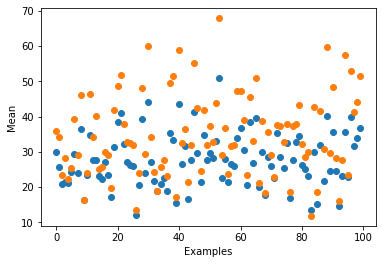

The Mean Squared Error: 68.09424505287686, and the R^2: 0.45280330698399485


In [170]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

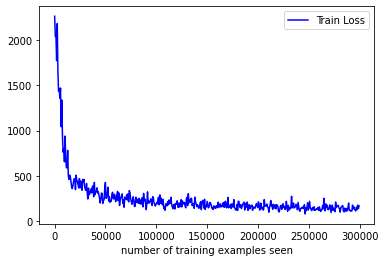

In [171]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.show()